# SENTIMENT ANALYSIS ON MOVIE REVIEWS
This model is designed to predict wether a movie review is positive or negative.
This model uses BERT(Bidirectional Encoder Representations from Transformers) model which is fine-tuned for movie review sentiment analysis.

### Import Dependencies

In [ ]:
!pip install -q -U "tensorflow-text==2.11.*"
!pip install tf-models-official

In [2]:
import os
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_text as text
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

### Load Dataset

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 8s 0us/step


### Training, Validating and Testing dataset

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Loading BERT Model from Tensorflow Hub

In [5]:
tfhub_handle_encoder = ("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

tfhub_handle_preprocess = ("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [6]:
def build_classifier_model():
  input_text = tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess,name="processing")
  encoder_input = preprocessing_layer(input_text)
  encoder = hub.KerasLayer(tfhub_handle_encoder,trainable=True,name="encoder")
  outputs = encoder(encoder_input)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1,activation="sigmoid",name='classifer')(net)
  return tf.keras.Model(input_text,net)

model = build_classifier_model()

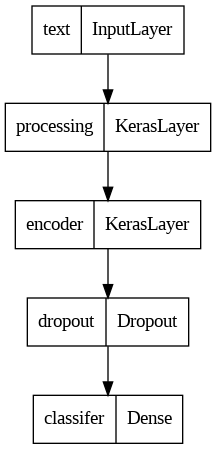

In [7]:
tf.keras.utils.plot_model(model)

### Model Training

In [9]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryCrossentropy()

epochs=5
steps_per_epochs = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epochs*epochs
num_warmup_steps = int(0.1 * num_train_steps)
optimizer = optimization.create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

In [10]:
model.compile(optimizer=optimizer,loss=loss,metrics=[metrics,"accuracy"])

In [11]:
history = model.fit(x=train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/5
625/625 [==============================] - 204s 311ms/step - loss: 0.4863 - binary_crossentropy: 0.4863 - accuracy: 0.7477 - val_loss: 0.3857 - val_binary_crossentropy: 0.3857 - val_accuracy: 0.8278
Epoch 2/5
625/625 [==============================] - 213s 341ms/step - loss: 0.3279 - binary_crossentropy: 0.3279 - accuracy: 0.8583 - val_loss: 0.3822 - val_binary_crossentropy: 0.3822 - val_accuracy: 0.8404
Epoch 3/5
625/625 [==============================] - 210s 336ms/step - loss: 0.2485 - binary_crossentropy: 0.2485 - accuracy: 0.8997 - val_loss: 0.3878 - val_binary_crossentropy: 0.3878 - val_accuracy: 0.8466
Epoch 4/5
625/625 [==============================] - 197s 315ms/step - loss: 0.1936 - binary_crossentropy: 0.1936 - accuracy: 0.9283 - val_loss: 0.4314 - val_binary_crossentropy: 0.4314 - val_accuracy: 0.8512
Epoch 5/5
625/625 [==============================] - 179s 286ms/step - loss: 0.1530 - binary_crossentropy: 0.1530 - accuracy: 0.9423 - val_loss: 0.4779 - val_binary

### Evaluate Model

In [14]:
loss ,_,accuracy = model.evaluate(test_ds)

print(f'Loss    : {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 107s 137ms/step - loss: 0.4606 - binary_crossentropy: 0.4606 - accuracy: 0.8562
Loss    : 0.4606248140335083
Accuracy: 0.8562399744987488


dict_keys(['loss', 'binary_crossentropy', 'accuracy', 'val_loss', 'val_binary_crossentropy', 'val_accuracy'])


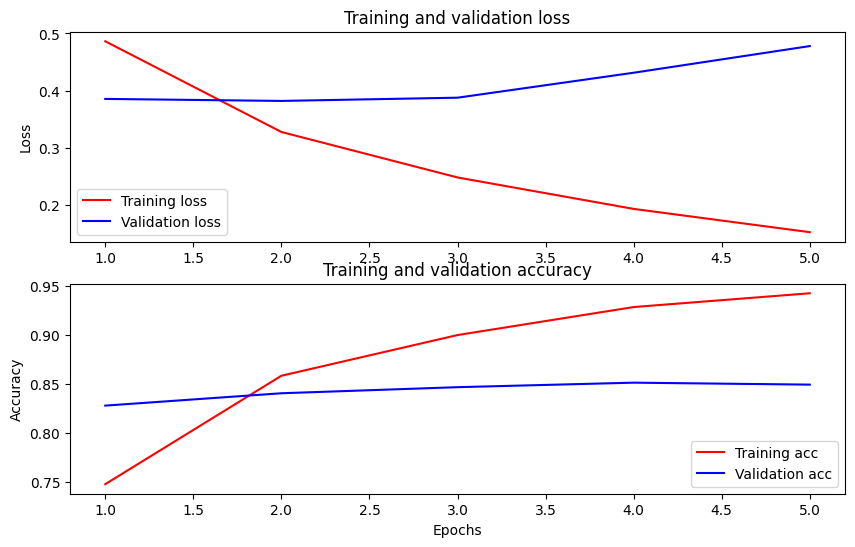

In [16]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Save Model

In [17]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

### Analysis Sentiment

In [19]:
reloaded_model = tf.saved_model.load(saved_model_path)

examples = [
    'this is such an amazing movie!',
    'this is the best movie.',
    'The movie was great!',
    'The movie was meh.',
    'The movie was good but not the best.',
    'The movie was terrible...'
]

def print_result(inputs,results):
  result_for_printing = [f'input:{inputs[i]:<30} : score:{results[i][0]:.6f}' for i in range(len(inputs))]
  print(*result_for_printing,sep='\n')
  print()

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the saved model:')
print_result(examples, reloaded_results)
print('Results from the model in memory:')
print_result(examples, original_results)

Results from the saved model:
input:this is such an amazing movie! : score:0.730985
input:this is the best movie.        : score:0.730750
input:The movie was great!           : score:0.730523
input:The movie was meh.             : score:0.720684
input:The movie was good but not the best. : score:0.717524
input:The movie was terrible...      : score:0.500836

Results from the model in memory:
input:this is such an amazing movie! : score:0.730985
input:this is the best movie.        : score:0.730750
input:The movie was great!           : score:0.730523
input:The movie was meh.             : score:0.720684
input:The movie was good but not the best. : score:0.717524
input:The movie was terrible...      : score:0.500836

